In [2]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
from matplotlib import pyplot as plt

import networkx as nx

from src.data.graph import load_graph_data

# 1. Data loading

In [3]:
graph_data = load_graph_data()
print("\nKeys:\n\t{}".format("    ".join(graph_data.keys())))

loading raw data from tsv files...
formatting articles...
formatting categories...
formatting links...
formatting paths...
formatting distance matrix...
building graph...

Keys:
	paths_finished    articles    links    shortest-path-distance-matrix    categories    paths_unfinished    graph


In [62]:
def get_edge_weights(dataframe: str) -> dict[tuple[str, str], int]:
    """
    Return a dictionary where the keys are tuples representing an edge (u, v) and values are the edges weights.
    The weight of an edge (u, v) is the number of times users went from u to v in their path.
    If a user clicked on '<', the article that was discarded does not contribute to the weight.
    """
    # Initialize all edge weights to zero
    edge_weights: dict[tuple[str, str], int] = {}
    for _, row in graph_data['links'].iterrows():
        source, dest = row['source_name'], row['target_name']
        edge_weights[(source, dest)] = 0
        
    for _, row in graph_data['articles'].iterrows():
        source = row['name'] 
        edge_weights[(source, '<')] = 0
    
    # Increase edge weights
    unrecognized_edges: set[tuple[str, str]] = set()
    for _, row in graph_data[dataframe].iterrows():
        path = row['path']
        clean_path = []  # Path without '<'
        for element in path:
            if element == '<':
                edge_weights[(clean_path[-1], '<')] += 1
                clean_path.pop()
            else:
                clean_path.append(element)
                
        for i in range(1, len(clean_path)):
            edge = (clean_path[i-1], clean_path[i])
            if edge not in edge_weights:
                unrecognized_edges.add(edge)
                edge_weights[edge] = 0
                
            edge_weights[edge] += 1
            
    
    if len(unrecognized_edges) > 0:
        print(f"Note that the following edges are present in '{dataframe} 'but not in 'links'")
        print(unrecognized_edges)
        
    assert(sum(edge_weights.values()) == 
        sum(graph_data[dataframe]['path'].apply(len)) 
        - sum(graph_data[dataframe]['path'].apply(lambda l: l.count('<')))
        - len(graph_data[dataframe]))
    
    return edge_weights

   

In [63]:
def get_graph(dataframe: str) -> nx.DiGraph:
    """
    Generates a directed graph from the given dataframe (either 'paths_finished' or 'paths_unfinished').
    The nodes of the graph are the articles.
    The weight of the edges of the graph represents the number of times users went from one article to another.
    A special node '<' is created. 
    The weight of an edge from u to '<' represents the number of times users clicked on the back button after visiting u.
    """
    graph = nx.DiGraph()
    
    # Add nodes to graph
    graph.add_node('<')
    for _, node in graph_data['articles'].iterrows():
        graph.add_node(node['name'])
        
    # Add edges to graph
    edge_weights = get_edge_weights(dataframe)
    for (source, dest), count in edge_weights.items():
        graph.add_edge(source, dest, weight=count)
        
    assert(graph.number_of_nodes() == len(graph_data['articles']) + 1)
    assert(abs(graph.number_of_edges() - len(graph_data['links']) - len(graph_data['articles'])) <= 4)
    return graph

In [64]:
finished_graph = get_graph('paths_finished')

Note that the following edges are present in 'paths_finished 'but not in 'links'
{('Claude_Monet', 'Édouard_Manet'), ('Bird', 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'), ('Republic_of_Ireland', 'Éire'), ('Finland', 'Åland')}


### Analyzing edges

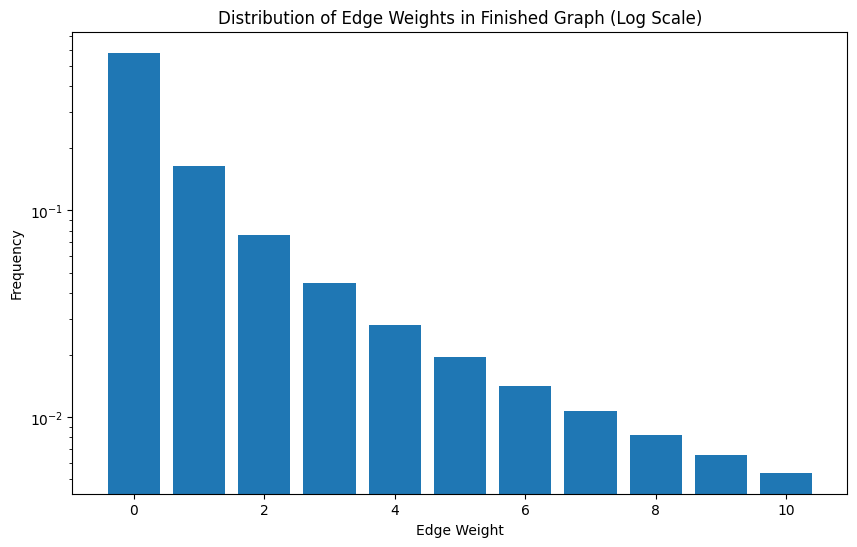

{0: 0.5799823278978231, 1: 0.164848582215439, 2: 0.07611053096634268, 3: 0.04434894369025624, 4: 0.02793798698690658, 5: 0.01959193509518837, 6: 0.014129648967788577, 7: 0.01068358904329665, 8: 0.008209494738533215, 9: 0.006586874447746807, 10: 0.005381958390232147, 11: 0.0048598280986424615, 12: 0.003662944814844566, 13: 0.0028757329906016547, 14: 0.002642782552815487, 15: 0.0022411438669772674, 16: 0.0022491766406940315, 17: 0.0019358984657402202, 18: 0.0016868824805205238, 19: 0.0014619648164511205, 20: 0.0012531126998152461, 21: 0.0012209816049481887, 22: 0.0009960639408787854, 23: 0.0010442605831793717, 24: 0.0009077034299943771, 25: 0.0007791790505261467, 26: 0.0005944252550405655, 27: 0.0005863924813238012, 28: 0.0005703269338902723, 29: 0.0005944252550405655, 30: 0.0004337697807052775, 31: 0.00044180255442204195, 32: 0.0004337697807052775, 33: 0.00038557313840469114, 34: 0.00030524540123704716, 35: 0.00038557313840469114, 36: 0.00023295043778616756, 37: 0.0003614748172543979, 3

In [66]:
# Extract edge weights
weights = [data['weight'] for _, _, data in finished_graph.edges(data=True)]
num_edges = len(weights)
frequencies = {w: weights.count(w) / num_edges for w in set(weights)}

# Cut off the tail for better visualization
cutoff = 0.005
filtered_frequencies = {k: v for k, v in frequencies.items() if v >= cutoff}

# Plot filtered_frequencies with log scale
plt.figure(figsize=(10, 6))
plt.bar(filtered_frequencies.keys(), filtered_frequencies.values())
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Distribution of Edge Weights in Finished Graph (Log Scale)')
plt.show()

print(frequencies)

As we can see in the above graph, 57% of the hyperlinks were never clicked by any user, 16% of the hyperlinks were clicked only once and 7% of the hyperlinks were clicked twice. Let's take a closer look at that.

Below are the 20 most clicked hyperlinks by any user

In [74]:
edges: list[int] = [(u, v, data['weight']) for u, v, data in finished_graph.edges.data()]
edges.sort(key= lambda x: x[2], reverse=True)
for i in range(20):
    print(f"Clicked {edges[i][2]} times: {edges[i][0]} -> {edges[i][1]}")

Clicked 536 times: Communication -> Telephone
Clicked 487 times: North_America -> United_States
Clicked 483 times: Animal -> Mammal
Clicked 473 times: United_States -> President_of_the_United_States
Clicked 472 times: Lion -> Zebra
Clicked 464 times: Europe -> United_Kingdom
Clicked 463 times: Brain -> Computer_science
Clicked 462 times: Mammal -> Zebra
Clicked 411 times: Norway -> Viking
Clicked 373 times: England -> Europe
Clicked 364 times: Seed -> Bean
Clicked 353 times: United_Kingdom -> England
Clicked 348 times: United_States -> North_America
Clicked 340 times: Fish -> Whale_shark
Clicked 317 times: Internet -> World_Wide_Web
Clicked 311 times: United_States -> <
Clicked 307 times: Science -> Chemistry
Clicked 303 times: World_War_II -> Adolf_Hitler
Clicked 302 times: Computer -> Microsoft_Windows
Clicked 299 times: English_language -> United_States
